# Angiosperm Seed Mass Analysis

This notebook is a sample analysis of results after we have ran our algorithm.

In [1]:
from treeHPYPcts import newick_from_file, RestFranchise, plots, TreeMCMC
import pandas as pd
import numpy as np
import os
import scipy as sp
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
inline_rc = dict(mpl.rcParams)

First we load in the results. To do this, we need to load in the tree (`RestFranchise` object), data (`pd.DataFrame`), and initialise an empty MCMC object to call `load_mcmc`.

In [2]:
data_file = 'data/Angio_GIFT_Families_Mean_Seed_Mass.csv'
tree_file = 'data/Angio_GIFT_Families_Mean_Seed_Mass.tree'
result_dir = 'results'
data = pd.read_csv(data_file).iloc[:, 0:2]
data.columns = ['node_name', 'obs']

tree = RestFranchise(newick=newick_from_file(tree_file))
tree.rescale()
mcmc = TreeMCMC(tree, data)
mcmc.load_mcmc(os.path.join(result_dir, 'mcmc.zip'))

If we look at the results under `results` we can see that there are a number of possible jump configurations.

In [3]:
summary = []
for f in sorted(os.listdir(os.path.join(result_dir, 'summary'))):
    if f.endswith('.csv'):
        summary.append(pd.read_csv(os.path.join(result_dir, 'summary', f)))

Some configurations have jumps on leaves that do not appear to be important, we can use this function to check how many leaves are affected by each jump and do a filtering.

In [9]:
affected_leaves = []
for s in summary:
    tree.jps = s['predicted_jp'].tolist()
    affected_leaves.append(tree.jp_affected_leave())

We then prune the jumps and obtain a list of unique candidate modes to test.

In [11]:
jps_pruned = []
for s, affected in zip(summary, affected_leaves):
    jp = s['predicted_jp'].copy()
    # if not jumps then do nothing
    if jp.sum() == 1:
        continue
    mask = affected.loc[affected['nleaf'] <= 5, 'node_idx']
    jp[mask] = 0
    jps_pruned.append(jp.tolist())

/tmp/ipykernel_38547/3891681569.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jp[mask] = 0
/tmp/ipykernel_38547/3891681569.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jp[mask] = 0
/tmp/ipykernel_38547/3891681569.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jp[mask] = 0
/tmp/ipykernel_38547/3891681569.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

In [12]:
unique_jps = np.unique(jps_pruned, axis = 0)

In [13]:
unique_jps.shape

(4, 605)

# Plotting

From this we have 4 modes to test. Note that this is a `numpy` array.

We can use this function to visualise how the jumps affect the tree.

In [15]:
idx = 0
tree.plot_with_jp(unique_jps[idx].tolist())

# a filename can be passed
tree.plot_with_jp(unique_jps[idx].tolist(), file = f'results/candidate{idx}.png')

The data itself can be visualised

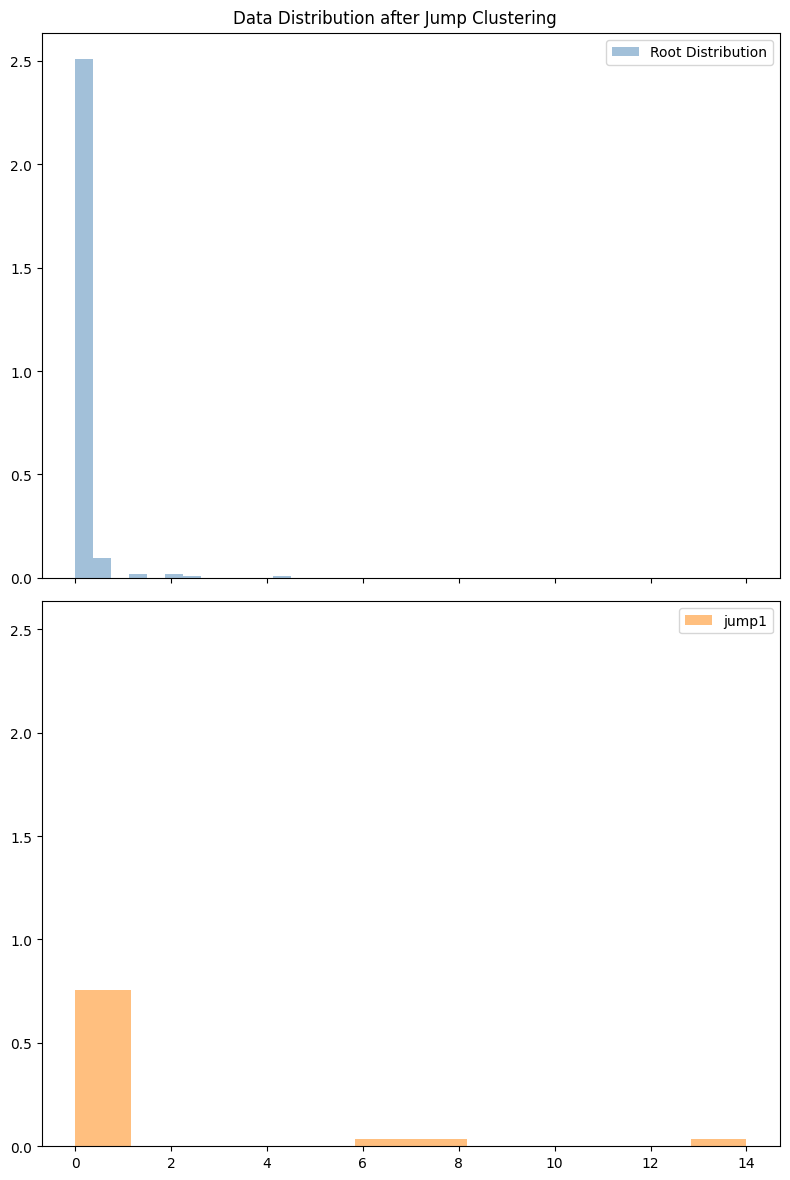

In [17]:
fig, ax = plots.plot_predicted_dist(tree,data,unique_jps[idx].tolist(), density=True, kde=False, bins = 12)

Now we run our comparisons. First we run particle filtering to compute the data likelihood for each jump configuration.

In [9]:
lls = mcmc.compare_jps_by_ll(*unique_jps)

In [10]:
avg_ll = []
for x in lls:
    avg_ll.append(sp.special.logsumexp(x[0]+ x[1]) - np.log(1000))

In [11]:
avg_ll

[-397.832652921035,
 -366.57166041973665,
 -368.05272136940323,
 -376.9413174640704,
 -398.21273577536545]

We can also run MCMC with a proposal which cycles through the jump configurations, taking the posterior probability of each jump configuration over a restricted state space.

In [7]:
samples = mcmc.compare_jps_by_mcmc(unique_jps.tolist(), num_chains = 8, parallel=True, n_cores = 5)

In [8]:
samples

[[0, 0, 0, 500, 0],
 [0, 0, 500, 0, 0],
 [0, 500, 0, 0, 0],
 [0, 0, 0, 500, 0],
 [0, 0, 500, 0, 0],
 [0, 500, 0, 0, 0],
 [0, 500, 0, 0, 0],
 [0, 3, 0, 497, 0]]

In [12]:
np.array(samples).mean(axis = 0) / 500

array([0.     , 0.37575, 0.25   , 0.37425, 0.     ])